# Gallery for DR6

The purpose of this notebook is to build the gallery for the sixth Legacy Survey data release, DR6.  The theme of this gallery is...

The parent sample is a diameter-limited (*D25>5* arcsec) sample defined and documented as part of the [Legacy Survey Large Galaxy Atlas](https://github.com/moustakas/LSLGA).  Here, we use the group catalog constructed in [this notebook](https://github.com/legacysurvey/legacypipe/blob/master/doc/nb/legacysurvey-gallery-groups-dr5.ipynb).

### Imports and paths

In [37]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from PIL import Image, ImageDraw, ImageFont
#from astrometry.util.starutil_numpy import hmsstring2ra

In [3]:
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables
from legacypipe.survey import ccds_touching_wcs, LegacySurveyData
from legacypipe.runbrick import run_brick

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2
nproc = 1 # hack because multiprocessing doesn't seem to be working in jupyter-dev

In [5]:
%matplotlib inline

### Preliminaries

Define the data release and specify the desired angular radius range (in arcmin) for the galaxies (and galaxy groups) that will end up in the gallery.

In [6]:
dr = 'dr6'
if dr == 'dr6':
    PIXSCALE = 0.470
else:
    raise NotImplementedError

In [7]:
gallerydir = os.path.join( os.getenv('SCRATCH'), dr, 'gallery' )
#cache_dir = os.path.join('global', 'cscratch1', 'sd', 'dstn', 'dr5-new-sky') # hack!
galleryfile = os.path.join(gallerydir, 'gallery-{}.fits'.format(dr))

#### Read the Open NGC catalog created by Mattia Verga:
https://github.com/mattiaverga/OpenNGC

```bash
wget https://raw.githubusercontent.com/mattiaverga/OpenNGC/master/NGC.csv
```

- Name: Object name composed by catalog + number
    NGC: New General Catalogue
    IC: Index Catalogue
    
- Type: Object type
    *: Star
    **: Double star
    *Ass: Association of stars
    OCl: Open Cluster
    GCl: Globular Cluster
    Cl+N: Star cluster + Nebula
    G: Galaxy
    GPair: Galaxy Pair
    GTrpl: Galaxy Triplet
    GGroup: Group of galaxies
    PN: Planetary Nebula
    HII: HII Ionized region
    DrkN: Dark Nebula
    EmN: Emission Nebula
    Neb: Nebula
    RfN: Reflection Nebula
    SNR: Supernova remnant
    Nova: Nova star
    NonEx: Nonexistent object
    
- RA: Right Ascension in J2000 Epoch (HH:MM:SS.SS)

- Dec: Declination in J2000 Epoch (+/-DD:MM:SS.SS)

- Const: Constellation where the object is located

- MajAx: Major axis, expressed in arcmin

- MinAx: Minor axis, expressed in arcmin

- PosAng: Major axis position angle (North Eastwards)

- B-Mag: Apparent total magnitude in B filter

- V-Mag: Apparent total magnitude in V filter

- J-Mag: Apparent total magnitude in J filter

- H-Mag: Apparent total magnitude in H filter

- K-Mag: Apparent total magnitude in K filter

- SurfBr (only Galaxies): Mean surface brigthness within 25 mag isophot (B-band), expressed in mag/arcsec2

- Hubble (only Galaxies): Morphological type (for galaxies)

- Cstar U-Mag (only Planetary Nebulae): Apparent magnitude of central star in U filter

- Cstar B-Mag (only Planetary Nebulae): Apparent magnitude of central star in B filter

- Cstar V-Mag (only Planetary Nebulae): Apparent magnitude of central star in V filter

- M: cross reference Messier number

- NGC: other NGC identification, if the object is listed twice in the catalog

- IC: cross reference IC number, if the object is also listed with that identification

- Cstar Names (only Planetary Nebulae): central star identifications

- Identifiers: cross reference with other catalogs

- Common names: Common names of the object if any

- NED Notes: notes about object exported from NED

- OpenNGC Notes: notes about the object data from OpenNGC catalog


In [8]:
names = ('name', 'type', 'ra_hms', 'dec_dms', 'const', 'majax', 'minax', 
         'pa', 'bmag', 'vmag', 'jmag', 'hmag', 'kmag', 'sbrightn', 'hubble', 
         'cstarumag', 'cstarbmag', 'cstarvmag', 'messier', 'ngc', 'ic', 
         'cstarnames', 'identifiers', 'commonnames', 'nednotes', 'ongcnotes')

In [9]:
NGC = ascii.read(os.path.join(gallerydir, 'NGC.csv'), delimiter=';', names=names)
NGC

name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97
IC0002,G,00:11:00.88,-12:49:22.3,Cet,0.98,0.32,142,15.46,--,12.26,11.48,11.17,23.45,Sb,--,--,--,--,--,--,--,"2MASX J00110081-1249206,IRAS 00084-1306,MCG -02-01-031,PGC 000778",--,--,B-Mag taken from LEDA.
IC0003,G,00:12:06.09,-00:24:54.8,Psc,0.93,0.67,53,15.1,--,11.53,10.79,10.54,23.5,E,--,--,--,--,--,--,--,"2MASX J00120604-0024543,MCG +00-01-038,PGC 000836,SDSS J001206.08-002454.7,SDSS J001206.09-002454.7,SDSS J001206.09-002454.8,SDSS J001206.10-002454.8",--,--,--
IC0004,G,00:13:26.94,+17:29:11.2,Peg,1.17,0.84,12,14.2,--,11.51,10.65,10.5,23.01,Sc,--,--,--,--,--,--,--,"2MASX J00132695+1729111,IRAS 00108+1712,MCG +03-01-029,PGC 000897,UGC 00123",--,--,--
IC0005,G,00:17:34.93,-09:32:36.1,Cet,0.99,0.66,9,14.57,--,11.5,10.85,10.5,23.4,E,--,--,--,--,--,--,--,"2MASX J00173495-0932364,MCG -02-01-047,PGC 001145,SDSS J001734.93-093236.0,SDSS J001734.93-093236.1",--,--,B-Mag taken from LEDA.
IC0006,G,00:18:55.04,-03:16:33.9,Psc,1.23,1.08,146,14.5,--,11.03,10.32,10.08,23.89,E,--,--,--,--,--,--,--,"2MASX J00185505-0316339,MCG -01-01-075,PGC 001228",--,--,--
IC0007,G,00:18:53.16,+10:35:40.9,Psc,0.9,0.63,174,14.7,--,11.33,10.57,10.26,23.22,S0,--,--,--,--,--,--,--,"2MASX J00185316+1035410,PGC 001216",--,--,--
IC0008,G,00:19:02.72,-03:13:19.5,Psc,0.82,0.34,129,15.16,--,12.7,12.08,12.08,23.4,E?,--,--,--,--,--,--,--,"2MASX J00190272-0313196,MCG -01-01-076,PGC 001234",--,--,B-Mag taken from LEDA.
IC0009,G,00:19:43.98,-14:07:18.8,Cet,0.59,0.46,122,15.41,--,12.38,11.71,11.28,22.88,Sa,--,--,--,--,--,--,--,"2MASX J00194400-1407184,MCG -02-02-001,PGC 001271",--,--,B-Mag taken from LEDA.
IC0010,G,00:20:17.34,+59:18:13.6,Cas,6.76,6.03,129,13.6,9.5,7.23,6.34,6.01,24.53,IB,--,--,--,--,--,--,--,"2MASX J00201733+5918136,IRAS 00175+5902,IRAS 00177+5900,MCG +10-01-001,PGC 001305,UGC 00192",--,The 2MASX position refers to the center of the IR isophotes.,--


In [41]:
keep = ( np.array(['*' not in tt for tt in NGC['type'].data]) * 
        np.array(['--' not in cc for cc in NGC['ra_hms'].data]) *
        np.array(['--' not in cc for cc in NGC['dec_dms'].data]) *
        (NGC['type'] != 'NonEx') * 
        (NGC['type'] != 'Dup') * 
        (NGC['type'] != 'Other') * 
        (NGC['type'] != 'Nova') * 
        (NGC['type'] != 'G') * 
        (NGC['type'] != 'GPair') * 
        (NGC['type'] != 'GTrpl') * 
        (ma.getdata(NGC['majax']) > 0.3) * (ma.getdata(NGC['majax']) < 2) * 
        (NGC['type'] != 'GGroup') )
nobj = np.count_nonzero(keep)
print('Keeping {} / {} objects'.format(nobj, len(NGC)))
cat = NGC[keep]
cat

Keeping 331 / 13953 objects


name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97
IC0132,HII,01:33:15.92,+30:56:44.2,Tri,0.67,0.55,--,14.87,14.82,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,Diameters taken from SIMBAD.
IC0133,HII,01:33:15.18,+30:53:18.2,Tri,0.45,0.45,--,18.28,18.45,14.48,13.91,13.51,--,--,--,--,--,--,--,--,--,"2MASX J01331516+3053196,IRAS 01304+3037",--,HII region in Messier 033. The IC object includes the surrounding star cloud.,Diameters taken from SIMBAD.
IC0135,HII,01:34:15.53,+30:37:12.3,Tri,0.4,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,HII region in Messier 033.,--
IC0142,HII,01:33:55.53,+30:45:28.1,Tri,0.5,--,--,11.3,14.2,--,--,--,--,--,--,--,--,--,--,--,--,--,--,HII region in Messier 033.,Dimensions taken from LEDA
IC0289,PN,03:10:19.26,+61:19:00.4,Cas,0.58,--,--,16.8,--,15.59,15.62,15.14,--,--,--,15.1,15.9,--,--,--,--,"IRAS 03062+6107,PK 138+02 1,PN G138.8+02.8",--,--,--
IC0466,HII,07:08:38.80,-04:19:04.8,Mon,1.0,--,--,12.71,12.06,10.56,10.25,9.94,--,--,--,--,--,--,--,--,--,"2MASX J07083878-0419046,IRAS 07061-0414",--,--,Dimensions taken from LEDA
IC0972,PN,14:04:25.91,-17:13:41.5,Vir,0.7,--,--,14.5,--,15.78,15.41,15.16,--,--,--,17.91,--,--,--,--,--,"PK 326+42 1,PN G326.7+42.2",--,--,--
IC1295,PN,18:54:37.13,-08:49:37.3,Sct,1.5,--,--,15.0,--,--,--,--,--,--,--,15.5,--,--,--,--,--,"IRAS 18519-0853,PK 25-04 2,PN G025.4-04.7",--,--,B-Mag taken from LEDA.
IC1454,PN,22:42:25.01,+80:26:32.0,Cep,0.47,--,--,14.8,--,--,--,--,--,--,--,18.8,--,--,--,--,--,"IRAS 22419+8010,PK 117+18 1,PN G117.5+18.9",--,--,B-Mag taken from LEDA.


#### Convert coordinates in decimal degrees.

In [42]:
coord = SkyCoord(ra=cat['ra_hms'], dec=cat['dec_dms'], unit=(u.hourangle, u.deg))
cat.add_column(Column(name='ra', unit='deg', length=nobj))
cat.add_column(Column(name='dec', unit='deg', length=nobj))
cat['ra'] = coord.ra.value
cat['dec'] = coord.dec.value

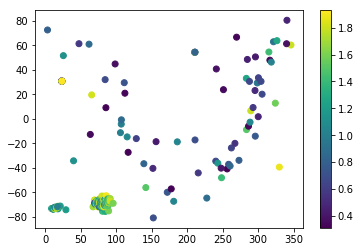

In [56]:
fig, ax = plt.subplots()
im = ax.scatter(cat['ra'], cat['dec'], c=cat['majax'])
plt.colorbar(im)

### Instantiate the LegacySurveyData class and then build the sample in the footprint.

In [13]:
survey = LegacySurveyData()

In [68]:
def simple_wcs(obj, diam):
    """Build a simple WCS object for a single object."""
    size = np.rint(diam / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(obj['ra'], obj['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [69]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [87]:
def build_sample_one(obj, factor=1.0, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given object.

    First generously find the nearest set of CCDs that are near the galaxy and
    then demand that there's 3-band coverage in a much smaller region centered
    on the galaxy.

    """
    print('Working on {}...'.format(obj['name'].strip()))
    diam = factor * ma.getdata(obj['majax']) * 60.0 # diameter [arcsec]
    wcs = simple_wcs(obj, diam)
    try:
        ccds = survey.ccds_touching_wcs(wcs) # , ccdrad=2*diam/3600)
    except:
        return [None, None]
    
    if ccds:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            if verbose:
                print('For {} (type={}) found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        obj['name'], obj['type'], len(ccds), obj['ra'], obj['dec'], obj['majax']))
            return [obj, ccds]
    return [None, None]

In [ ]:
def build_sample(factor=1.0):
    """Build the full sample with grz coverage in DR6."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, factor, True) ) # the False refers to verbose=False

    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))

    # Remove non-matching objects and write out the sample
    res = list(zip(*result))
    outcat = vstack(list(filter(None, res[0])))
    outccds = merge_tables(list(filter(None, res[1])))
    print('Found {}/{} objects in the DR6 footprint.'.format(len(outcat), len(cat)))
    
    # Add a fracmasked column.
    outcat.add_column(Column(name='fracmasked', shape=(3,), length=len(outcat), dtype='f2'))
    
    return outcat

In [ ]:
sample = build_sample()

In [ ]:
stop

In [149]:
run_brick(None, survey, radec=(ra, dec), pixscale=PIXSCALE, early_coadds=True,
          width=size, height=size, stages=['image_coadds'], splinesky=True)

Total Memory Available to Job:
Maximum VMEM                      (RLIMIT_AS      ) :                   -1                   -1
Maximum core file size            (RLIMIT_CORE    ) :                    0                   -1
Maximum CPU time                  (RLIMIT_CPU     ) :                   -1                   -1
Maximum file size                 (RLIMIT_FSIZE   ) :                   -1                   -1
Maximum heap size                 (RLIMIT_DATA    ) :                   -1                   -1
Maximum stack size                (RLIMIT_STACK   ) :                   -1                   -1
Maximum resident set size         (RLIMIT_RSS     ) :                   -1                   -1
Maximum number of processes       (RLIMIT_NPROC   ) :                 2048                 8192
Maximum number of open files      (RLIMIT_NOFILE  ) :                 4096                65536
Maximum lockable memory address   (RLIMIT_MEMLOCK ) :                   -1                   -1
RA,Dec: (

NothingToDoError: No CCDs touching brick

In [30]:
obj, ccds = build_sample_one(cat[0])

Working on IC0132...
Searching /global/projecta/projectdirs/cosmo/work/legacysurvey/dr6/survey-ccds-dr6plus.kd.fits
199 CCDs within 1.0 deg of RA,Dec (23.316, 30.946)
Converted image_filename from |S55 to <U55
Converted camera from |S7 to <U7
Converted ccdname from |S4 to <U4
Converted object from |S24 to <U24
Converted propid from |S10 to <U10
Converted filter from |S1 to <U1


In [147]:
obj = cat[0]         
size = np.rint(2*obj['majax'] * 60 / PIXSCALE).astype('int') # [pixels]
ra = obj['ra'].astype('f4')
dec = obj['dec'].astype('f4')
print(ra, dec, size)
obj

23.3163 30.9456 171


name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes,ra,dec
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97,float64,float64
IC0132,HII,01:33:15.92,+30:56:44.2,Tri,0.67,0.55,--,14.87,14.82,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,Diameters taken from SIMBAD.,23.3163333333,30.9456111111


### Build the parent sample of galaxies in the DR5 footprint.

In [14]:
def _uniqccds(ccds):
    '''Get the unique set of CCD files.'''
    ccdfile = []
    [ccdfile.append('{}-{}'.format(expnum, ccdname)) for expnum,
     ccdname in zip(ccds.expnum, ccds.ccdname)]
    _, indx = np.unique(ccdfile, return_index=True)
    return ccds[indx]

In [10]:
bricks = survey.get_bricks()
allccds = survey.get_annotated_ccds()
cut = survey.photometric_ccds(allccds)
if cut is not None:
    allccds.cut(cut)
cut = survey.ccd_cuts(allccds)
allccds.cut(cut == 0)
print('Read {} CCDs.'.format(len(allccds)))

Converted brickname from |S8 to <U8
Reading annotated CCDs from /global/cscratch1/sd/desiproc/dr5/ccds-annotated-run19.fits.gz
Converted object from |S37 to <U37
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Converted image_filename from |S51 to <U51
Converted plver from |S6 to <U6
Got 73860 CCDs
Reading annotated CCDs from /global/cscratch1/sd/desiproc/dr5/ccds-annotated-decals.fits.gz
Converted object from |S37 to <U37
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Converted image_filename from |S61 to <U61
Converted plver from |S6 to <U6
Got 493440

In [19]:
%time sample = build_sample()
sample

Found 271/1300 galaxies and groups in the DR5 footprint.
CPU times: user 28.7 s, sys: 164 ms, total: 28.9 s
Wall time: 28.9 s


GROUPID,GALAXY,NMEMBERS,RA,DEC,DIAMETER,D25MAX,D25MIN,BRICKNAME [6],FRACMASKED [3]
int32,str1000,int32,float64,float64,float32,float32,float32,bytes20,float16
614652,"NGC0127,NGC0128,NGC0130",3,7.3139,2.86903333333,189.737,189.737,42.4767,0073p027 ..,0.0 .. 0.0
615005,"PGC1036047,PGC1036361,PGC1036593",3,8.2232,-6.13836333333,201.951,53.4751,28.0641,0081m062 ..,0.0 .. 0.0
615052,"PGC1028413,PGC143577,PGC143579",3,8.3796,-6.82209333333,151.885,27.4253,24.4428,0084m067 ..,0.0 .. 0.0
615465,"PGC1101085,PGC1100823,PGC1100450",3,9.30705,-2.13501666667,141.452,37.8574,25.0122,0093m022 ..,0.0 .. 0.0
615699,"NGC0192,NGC0196,NGC0197",3,9.8195,0.889566666667,212.301,122.504,55.9953,0098p007 ..,0.0 .. 0.0
616634,"PGC842319,NGC0247B,ESO540-024,ESO540-025,PGC002798",5,11.89698,-20.456582,480.295,62.8277,31.4885,0118m205 ..,0.0 .. 0.0
616934,"PGC090503,PGC1244573,PGC1244244",3,12.65625,3.07869666667,151.249,39.6416,28.0641,0126p030 ..,0.0 .. 0.0
617056,"IC0055,PGC1328252,PGC1328284",3,12.95565,7.69844333333,258.555,47.6597,26.1909,0129p077 ..,0.0 .. 0.0
617185,"PGC173062,PGC173063,PGC173070",3,13.28545,-3.63262,196.097,47.6597,30.7717,0131m037 ..,0.0 .. 0.0


### Retrieve FITS cutouts of each galaxy in each band.

We also compute the fraction of masked pixels in each band (so we can do some quality cuts, below) and then write out the final sample.

In [20]:
fitsdir = os.path.join(gallerydir, 'fits')
if not os.path.isdir(fitsdir):
    os.mkdir(fitsdir)

In [21]:
def galaxyname(gal, html=False):
    """We want to prevent the output FITS/png filenames from arbitrarily long
    so we use the following convention:
    
    1 member - use the galaxy name
    2-3 members - join the individual galaxy names with a hyphen
    >3 members - use the groupid with format :08d
    
    """
    if gal['NMEMBERS'] > 500:
        galaxy = 'group{:08d}'.format(gal['GROUPID'])
    else:
        if html:
            galaxy = gal['GALAXY'].strip().lower().replace(',', ' ')
        else:
            galaxy = gal['GALAXY'].strip().lower().replace(',', '-')
    
    return galaxy

In [22]:
def fits_cutouts(verbose=False):
    """Grab cutouts of every galaxy and also quickly compute the fraction of 
    pixels that are masked in each image (in fracmasked).
    
    """
    for jj, gal in enumerate(sample):
        galaxy = galaxyname(gal)
        if gal['NMEMBERS'] == 1:
            size = np.ceil(GALAXY_DIAMFACTOR*gal['DIAMETER']/PIXSCALE).astype('int16') # [pixels]
        else:
            size = np.ceil(GROUP_DIAMFACTOR*gal['DIAMETER']/PIXSCALE).astype('int16') # [pixels]

        # Get a FITS cutout and then split the file into three individual bands.
        baseurl = 'http://legacysurvey.org/viewer-dev/fits-cutout/'
        fitsurl = '{}?ra={:.6f}&dec={:.6f}&pixscale={:.3f}&size={:g}&layer=decals-{}'.format(
            baseurl, gal['RA'], gal['DEC'], PIXSCALE, size, dr)
        fitsfile = os.path.join(fitsdir, '{}.fits'.format(galaxy))
        cmd = 'wget --continue -O {:s} "{:s}"' .format(fitsfile, fitsurl)
        if os.path.isfile(os.path.join(fitsdir, '{}-{}.fits'.format(galaxy, 'g'))):
            if verbose:
                print('Skipping galaxy {}'.format(galaxy))
        else:
            if verbose:
                print(cmd)
            os.system(cmd)

            img, hdr = fitsio.read(fitsfile, ext=0, header=True)
            for ii, band in enumerate(['g', 'r', 'z']):
                bandfile = os.path.join(fitsdir, '{}-{}.fits'.format(galaxy, band))
                #print('  Writing {}'.format(bandfile))
                sample['FRACMASKED'][jj][ii] = np.sum(img[ii, :, :] == 0) / img[ii, :, :].size
                fitsio.write(bandfile, img[ii, :, :], clobber=True, header=hdr)        
            #print('  Removing {}'.format(fitsfile))
            os.remove(fitsfile)

In [23]:
%time fits_cutouts(verbose=False)

CPU times: user 8.88 s, sys: 17.6 s, total: 26.5 s
Wall time: 19min 23s


In [24]:
if os.path.isfile(galleryfile):
    os.remove(galleryfile)
    
print('Writing {}'.format(galleryfile))
sample.write(galleryfile)

Writing /global/cscratch1/sd/ioannis/dr5/gallery/gallery-dr5.fits


### Build a color image using trilogy.py

Here we require no more than 2% of the pixels in *all* the FITS images to be masked (i.e., to have values of zero) before generating a PNG file.  Then, after the PNG image has been generated, we read it back in and add a scale bar and a galaxy label.

In [25]:
fraccut = 0.02 # [fraction]

In [26]:
pngdir = os.path.join(gallerydir, 'png')
if not os.path.isdir(pngdir):
    os.mkdir(pngdir)

In [27]:
barlen30 = np.round(30.0 / PIXSCALE).astype('int')
fonttype = os.path.join(gallerydir, 'Georgia.ttf')

In [28]:
def make_png(pngsample, verbose=False):
    """Build a png file for each galaxy / group using Trilogy. 
    
    """
    for gal in pngsample:
        galaxy = galaxyname(gal)
        
        pngfile = os.path.join(pngdir, '{}.png'.format(galaxy))
        thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(galaxy))

        paramfile = os.path.join(pngdir, '{}.in'.format(galaxy))
        with open(paramfile, 'w') as param:
            param.write('B\n')
            param.write(os.path.join(fitsdir, '{}-g.fits\n'.format(galaxy)))
            param.write('\n')
            param.write('G\n')
            param.write(os.path.join(fitsdir, '{}-r.fits\n'.format(galaxy)))
            param.write('\n')        
            param.write('R\n')
            param.write(os.path.join(fitsdir, '{}-z.fits\n'.format(galaxy)))
            param.write('\n')
            param.write('indir {}\n'.format(fitsdir))
            param.write('outname {}\n'.format(pngfile))
            param.write('noiselum 0.3\n')
            param.write('satpercent 0.001\n')
            param.write('samplesize 1000\n')
            param.write('stampsize 5000\n')
            #param.write('scaling {}\n'.format(os.path.join(gallerydir, 'levels.txt')))
            param.write('colorsatfac 0.95\n')
            param.write('deletetests 1\n')
            param.write('showstamps 0\n')
            param.write('show 0\n')
            param.write('legend 0\n')
            param.write('testfirst 0\n')
        param.close()
        
        trilogy = os.path.join(os.getenv('LEGACYPIPE_DIR'), 'py', 'legacyanalysis', 'trilogy.py')
        cmd = 'python {} {}'.format(trilogy, paramfile)
        #print(cmd)
        os.system(cmd)
        for txt in ('levels.txt', 'trilogyfilterlog.txt'):
            thisfile = os.path.join(os.getenv('LEGACYPIPE_DIR'), 'doc', 'nb', txt)
            os.remove(thisfile)
        os.remove(os.path.join(pngdir, '{}_filters.txt'.format(galaxy)))
        os.remove(os.path.join(pngdir, '{}.in'.format(galaxy)))
    
        im = Image.open(pngfile)
        sz = im.size
        fntsize = np.round(sz[0]/28).astype('int')
        width = np.round(sz[0]/175).astype('int')
        font = ImageFont.truetype(fonttype, size=fntsize)
        draw = ImageDraw.Draw(im)
        # Label the galaxy name--
        draw.text((0+fntsize*2, 0+fntsize*2), galaxy.upper(), font=font)
        #draw.text((sz[0]-fntsize*6, sz[1]-fntsize*3), galaxy.upper(), font=font)
        # Add a 30 arcsec scale bar--
        x0, x1, yy = sz[1]-fntsize*2-barlen30, sz[1]-fntsize*2, sz[0]-fntsize*2
        draw.line((x0, yy, x1, yy), fill='white', width=width)
        im.save(pngfile)    
        
        # Generate a thumbnail
        cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
        os.system(cmd)
        
        if verbose:
            print('Wrote {}'.format(pngfile))    

In [29]:
indx = np.sum(sample['FRACMASKED'] < fraccut, axis=1) == 3
pngsample = sample[indx]
print('Identified {} groups with <2% pixels masked in grz.'.format(len(pngsample)))

Identified 174 groups with <2% pixels masked in grz.


In [30]:
pngsample

GROUPID,GALAXY,NMEMBERS,RA,DEC,DIAMETER,D25MAX,D25MIN,BRICKNAME [6],FRACMASKED [3]
int32,str1000,int32,float64,float64,float32,float32,float32,bytes20,float16
614652,"NGC0127,NGC0128,NGC0130",3,7.3139,2.86903333333,189.737,189.737,42.4767,0073p027 ..,4.7684e-07 .. 7.1526e-06
615005,"PGC1036047,PGC1036361,PGC1036593",3,8.2232,-6.13836333333,201.951,53.4751,28.0641,0081m062 ..,5.3823e-05 .. 7.7784e-05
615052,"PGC1028413,PGC143577,PGC143579",3,8.3796,-6.82209333333,151.885,27.4253,24.4428,0084m067 ..,0.0 .. 0.0
615465,"PGC1101085,PGC1100823,PGC1100450",3,9.30705,-2.13501666667,141.452,37.8574,25.0122,0093m022 ..,1.2875e-05 .. 9.4175e-06
616934,"PGC090503,PGC1244573,PGC1244244",3,12.65625,3.07869666667,151.249,39.6416,28.0641,0126p030 ..,0.0 .. 0.0
617185,"PGC173062,PGC173063,PGC173070",3,13.28545,-3.63262,196.097,47.6597,30.7717,0131m037 ..,9.6858e-05 .. 0.0
618099,"PGC003597,PGC914550,PGC173260",3,15.12245,-15.18764,219.216,48.7698,25.0122,0151m152 ..,0.00061321 .. 0.0
619319,"PGC929534,PGC929768,PGC004283",3,17.8845,-14.0488366667,185.516,45.5147,26.1909,0178m140 ..,0.0010471 .. 6.1274e-05
619432,"PGC1036232,PGC1036166,PGC144001,PGC1036077",4,18.1082625,-6.1616275,288.214,54.7206,24.4428,0179m062 ..,0.0 .. 1.7881e-07


In [31]:
%time make_png(pngsample, verbose=False)

CPU times: user 2min 15s, sys: 10 s, total: 2min 25s
Wall time: 12min 42s


### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do
  * rsync -auvP /global/cscratch1/sd/ioannis/dr5/gallery/png /global/project/projectdirs/cosmo/www/temp/ioannis/dr5/gallery/
  * rsync -auvP /global/cscratch1/sd/ioannis/dr5/gallery/index.html /global/project/projectdirs/cosmo/www/temp/ioannis/dr5/gallery/

In [58]:
reject = ['pgc1667789-pgc1667493-pgc1666803-pgc1666735',
          'pgc156324-pgc156326-pgc1151284',
          'pgc200252-pgc1591421-ngc3040',
          'pgc008096-ugc01617-ugc01618-pgc008116-ugc01620'
         ]
toss = np.zeros(len(pngsample), dtype=bool)
for ii, gg in enumerate(pngsample['GALAXY']):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in gg.lower().replace(',', '-')
        if toss[ii]:
            break
print('Rejecting {} groups.'.format(np.sum(toss)))
pngkeep = pngsample[~toss]
if np.sum(toss) > 0:
    pngrej = pngsample[toss]
else:
    pngrej = []

Rejecting 4 groups.


In [62]:
nperrow = 5
nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
pngsplit = np.array_split(pngkeep, nrow)
print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

Splitting the sample into 34 rows with 5 mosaics per row.


In [63]:
htmlfile = os.path.join(gallerydir, 'index.html')
baseurl = 'http://legacysurvey.org/viewer-dev'

In [66]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('img.ls-gallery {display: block;}\n')
    html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>Image Gallery of Galaxy Groups</h1>\n')
    html.write("""<p>This gallery highlights some of the galaxy groups in the DR5 footprint.  The
    groups were identified using an input catalog of galaxies with an apparent angular diameter greater than 24 arcsec
    and a friends-of-friends algorithm with a linking length of 2.5 arcminute.  The color mosaics
    were generated using <a class="reference external" href="http://www.stsci.edu/~dcoe/trilogy">trilogy.py</a>.  
    Each thumbnail links to a larger image while the galaxy names below the thumbnails link to the
    <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  For reference, the horizontal white bar in 
    each image represents 30 arcsec.</p>\n""")
    html.write("""<p><a href="http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr4/gallery/">
    Visit the DR4 Gallery.</a></p>\n""")
    html.write('<table><tbody>\n')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for gal in pngrow:
            galaxy = galaxyname(gal)
            pngfile = os.path.join('png', '{}.png'.format(galaxy))
            thumbfile = os.path.join('png', 'thumb-{}.png'.format(galaxy))
            img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, galaxy.upper())
            html.write('<td class="ls-gallery"><a href="{}"><img {} /></a></td>\n'.format(pngfile, img))
        html.write('</tr><tr>\n')
        for gal in pngrow:
            galaxy = galaxyname(gal, html=True)
            href = '{}/?layer=decals-{}&ra={:.8f}&dec={:.8f}&zoom=13'.format(baseurl, dr, gal['RA'], gal['DEC'])
            html.write('<td class="ls-gallery"><a href="{}">{}</a></td>\n'.format(href, galaxy.upper()))
        html.write('</tr>\n')
    html.write('</table></tbody>')
    html.write('</body></html>\n')

In [60]:
htmlfile_reject = os.path.join(gallerydir, 'index-reject.html')

In [61]:
if len(pngrej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><body>\n')
        for gal in pngrej:
            galaxy = galaxyname(gal)
            pngfile = os.path.join('png', '{}.png'.format(galaxy))
            img = 'class="ls-gallery" src="{}" alt="{}"'.format(pngfile, galaxy.upper())
            html.write('<a href="{}/?ra={:.8f}&dec={:.8f}&layer=decals-{}"><img {}></a>\n'.format(
                    baseurl, gal['RA'], gal['DEC'], dr, img))
        html.write('</body></html>\n')